Project 2: Web Scraping and Regression<br/>

The goal of this project is to build a linear regression model to predict some numerical value using data scraped from the world wide web.

For this project, I scraped Craigslist car postings in the SF Bay Area. The time period for my scrape was between July 10,2020 and July 12,2020. I collect attributen and see how they correlate with price, my target variable.

In this notebook, I combine my July 10-12 Craigslist DataFrames and clean them up. I add columns, remove columns, and generally making sure the data is workable. Finally, I perform exploratory data analysis to examine the relationship between the different variables I have with price.

#### Notebook Table of Contents

1. Imports
2. Data Cleaning
3. Exploratory Data Analysis

#### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

%matplotlib inline

### 2. Data Cleaning <br/>

In this section, I will be taking a look at the data I collected and adding in columns, removing columns, and filling in any information that may be missing.

In [2]:
with open('data/july_10.pickle', 'rb') as read_file:
    july_10_df = pickle.load(read_file)

with open('data/july_11.pickle', 'rb') as read_file:
    july_11_df = pickle.load(read_file)
    
with open('data/july_12.pickle', 'rb') as read_file:
    july_12_df = pickle.load(read_file)

car_df = pd.concat([july_10_df, july_11_df, july_12_df])

In [3]:
car_df.head()

,condition,cylinders,drive,fuel,odometer,paint color,title status,transmission,type,year,make,model,post_title,price,location,posting_date,url,VIN,size
0,good,8 cylinders,rwd,gas,160000,black,salvage,automatic,SUV,2013,chevy,tahoe lt,2013 Chevy Tahoe salvage con 160000 millas,$10300,concord / pleasant hill / martinez,2020-07-10 09:14,https://sfbay.craigslist.org/eby/cto/d/concord...,NaN,NaN
1,excellent,4 cylinders,4wd,gas,36368,white,clean,automatic,SUV,2017,volvo,xc90,✭2017 Volvo XC90 R-Design,$34800,san rafael,2020-07-10 09:14,https://sfbay.craigslist.org/nby/ctd/d/2017-vo...,YV4102KMXH1131603,mid-size
2,NaN,4 cylinders,4wd,gas,59541,black,clean,other,SUV,2013,Audi,Q5,2013 Audi Q5 quattro 4dr 2.0T Premium Plus,$17900,2013 Audi Q5,2020-07-10 09:14,https://sfbay.craigslist.org/scz/ctd/d/montere...,WA1LFAFP2DA057459,NaN
3,NaN,4 cylinders,fwd,gas,102693,black,clean,automatic,other,2013,Hyundai,Veloster,2013 Hyundai Veloster - E-Z Financing!,$8499,None,2020-07-10 09:14,https://sfbay.craigslist.org/sfc/ctd/d/san-jos...,KMHTC6AE1DU158388,NaN
4,NaN,4 cylinders,fwd,gas,64183,white,clean,automatic,sedan,2012,Mitsubishi,Galant,2012 Mitsubishi Galant - E-Z Financing!,$6499,None,2020-07-10 09:13,https://sfbay.craigslist.org/sfc/ctd/d/san-jos...,4A32B3FF9CE017464,NaN


In [4]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7443 entries, 0 to 1908
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   condition     4639 non-null   object
 1   cylinders     4253 non-null   object
 2   drive         5334 non-null   object
 3   fuel          7347 non-null   object
 4   odometer      6460 non-null   object
 5   paint color   5441 non-null   object
 6   title status  7339 non-null   object
 7   transmission  7275 non-null   object
 8   type          5621 non-null   object
 9   year          7237 non-null   object
 10  make          7237 non-null   object
 11  model         7237 non-null   object
 12  post_title    7348 non-null   object
 13  price         7027 non-null   object
 14  location      7095 non-null   object
 15  posting_date  7348 non-null   object
 16  url           7443 non-null   object
 17  VIN           4464 non-null   object
 18  size          2451 non-null   object
dtypes: obj

First glance at the data:
* 7, 443 rows
* Many columns have null objects.

The location data I scraped is messy and prone to user error. I would rather use Craigslist's URL to get consistent location data. For example, I can parse `eby`, or east bay, from https://sfbay.craigslist.org/eby/cto/d/concord.

Additionally, I want to add the number of attributes I collected as well as the length of the post title to add some numerical features that can be used in my regression analysis.

In [5]:
# parse through the URL to get location and spell out abbreviations
car_df["URL_LOCATION"] = car_df["url"].str.slice(29, 32).astype(str)

url_location_dict = {"eby":"east_bay", "sby":"south_bay", "sfc":"san_francisco",
                     "nby":"north_bay", "pen":"peninsula","scz":"santa_cruz"}
car_df["URL_LOCATION"] = car_df["URL_LOCATION"].map(url_location_dict)

# calculate the number of car attributes collected per post
car_df["attribute_number"] = (car_df[["condition", "cylinders", "drive", "fuel", "odometer",
                                      "paint color", "title status", "transmission", "type",
                                      "year", "make", "model", "location", "VIN", "size"]]
                              .count(axis=1)
                             )

# calculate the length of the post title
car_df["post_title_length"] = car_df["post_title"].astype(str).apply(lambda title: len(title))

Next, I want to remove any rows where price, year, and odometer are not known. <br/>
Price is crucial to my model because it's my target variable. Year and odometer readings are also crucial for my analysis.

In [6]:
# drop any rows where price, year, odometer are not known. these variables are crucial to my model
print(car_df.shape) # 7,443 rows originally
car_df.dropna(subset=["price", "year", "odometer"], inplace=True)
print(car_df.shape) # 6,140 rows after dropping those rows meaning 1,303 rows were dropped

(7443, 22)
(6140, 22)


In [7]:
# turn years into a numerical feature by calculating the car's age(current year is 2020).
# set the lowest age to 1 because an age of 0 causes problems when trying to do a log transformation
car_df["car_age"] = (car_df["year"]
                     .astype(int)
                     .apply(lambda year: (2020 - year + 1) if year < 2020 else 1)
                    )
car_df.sample(5)

,condition,cylinders,drive,fuel,odometer,paint color,title status,transmission,type,year,...,price,location,posting_date,url,VIN,size,URL_LOCATION,attribute_number,post_title_length,car_age
876,excellent,4 cylinders,NaN,gas,174000,silver,clean,automatic,NaN,2007,...,$4299,concord / pleasant hill / martinez,2020-07-09 17:44,https://sfbay.craigslist.org/eby/cto/d/concord...,NaN,NaN,east_bay,11,17,14
2095,good,NaN,fwd,other,55830,black,clean,automatic,sedan,2017,...,$17400,CALL 510-470-7297,2020-07-10 10:11,https://sfbay.craigslist.org/eby/ctd/d/dublin-...,1HGCR2F59HA234906,NaN,east_bay,13,32,4
1044,excellent,4 cylinders,4wd,gas,87000,black,clean,manual,hatchback,2002,...,$6750,redwood city,2020-07-11 11:50,https://sfbay.craigslist.org/pen/ctd/d/redwood...,JF1GG68562G805871,mid-size,peninsula,15,46,19
2806,excellent,NaN,NaN,gas,58000,NaN,clean,automatic,NaN,2010,...,$9500,Phoenix - Arizona,2020-07-08 13:43,https://sfbay.craigslist.org/sby/ctd/d/2010-su...,NaN,NaN,south_bay,9,64,11
787,good,8 cylinders,NaN,gas,89409,silver,clean,automatic,sedan,2007,...,$12995,hayward / castro valley,2020-07-11 14:04,https://sfbay.craigslist.org/eby/ctd/d/hayward...,WDDNG71X77A060907,NaN,east_bay,13,53,14


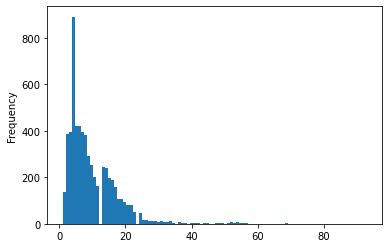

In [8]:
car_df["car_age"].plot.hist(bins=100);

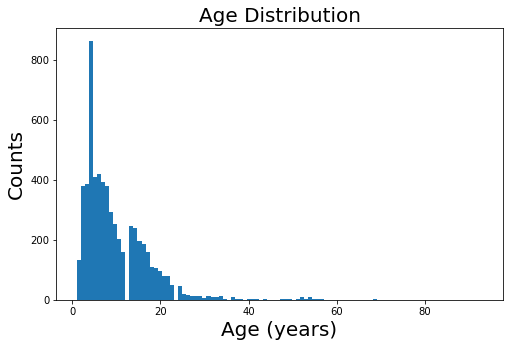

In [43]:
plt.figure(figsize=(8,5))
plt.title("Age Distribution", fontsize=20)
plt.xlabel("Age (years)", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.hist(car_df["car_age"], bins=100)
plt.savefig("images/age_distribution.png",format='png');

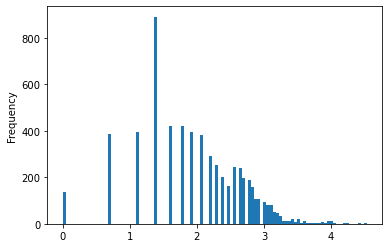

In [9]:
# there are a couple outliers and the data is skewed, so I will add a log transform column
car_df["car_age_log"] = np.log(car_df["car_age"])
car_df["car_age_log"].plot.hist(bins=100);

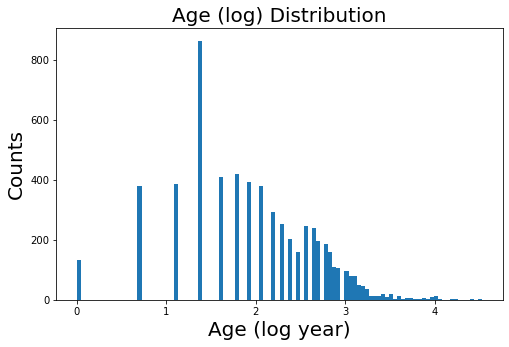

In [44]:
plt.figure(figsize=(8,5))
plt.title("Age (log) Distribution", fontsize=20)
plt.xlabel("Age (log year)", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.hist(car_df["car_age_log"], bins=100)
plt.savefig("images/age_log_distribution.png",format='png');

I have a lot of categorical features, and there are a lot of features with null values that would be hard to impute.
Therefore, I will remove the following columns: condition, cylinders, drive, paint color, type, make, model, and size.

Because I have already calculated post title length and location from the url, I will also remove the post_title and location columns.

Finally, I will remove posting_date, url, and VIN because they aren't relevant for my analysis.

To sum up, I want to remove the following columns: condition, cylinders, drive, paint color, type, make, model, post_title, location, posting_date, url, VIN, and size.

In [10]:
car_df = (car_df.drop(axis=1,
          columns=["condition", "cylinders", "drive", "paint color", "type", "make", "model",
                  "size", "post_title", "location", "posting_date", "url", "VIN"])
         )
car_df.sample(5)

,fuel,odometer,title status,transmission,year,price,URL_LOCATION,attribute_number,post_title_length,car_age,car_age_log
326,gas,115747,clean,automatic,2010,$12899,south_bay,13,49,11,2.397895
966,gas,21000,salvage,automatic,2018,$14995,san_francisco,13,70,3,1.098612
1986,hybrid,21882,clean,other,2017,$20900,santa_cruz,12,34,4,1.386294
1019,gas,123261,clean,automatic,2010,$11940,south_bay,12,33,11,2.397895
49,gas,151258,clean,automatic,1999,$3100,south_bay,8,20,22,3.091042


In [11]:
# Fuel, title status, and transmission still have null values
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6140 entries, 0 to 1908
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuel               6139 non-null   object 
 1   odometer           6140 non-null   object 
 2   title status       6131 non-null   object 
 3   transmission       6069 non-null   object 
 4   year               6140 non-null   object 
 5   price              6140 non-null   object 
 6   URL_LOCATION       6140 non-null   object 
 7   attribute_number   6140 non-null   int64  
 8   post_title_length  6140 non-null   int64  
 9   car_age            6140 non-null   int64  
 10  car_age_log        6140 non-null   float64
dtypes: float64(1), int64(3), object(7)
memory usage: 575.6+ KB


In [12]:
# impute 1 transmission value with "diesel" after looking at the Craigslist post
car_df[car_df["fuel"].isna()]
car_df.loc[car_df["fuel"].isna(), "fuel"] = "diesel"

# will impute 71 null transmission values with "automatic" since that's more common
car_df.loc[car_df["transmission"].isna(), "transmission"] = "automatic"
car_df["transmission"].value_counts()

# impute 9 null title status values with "missing"
car_df["title status"] = car_df["title status"].fillna("missing")

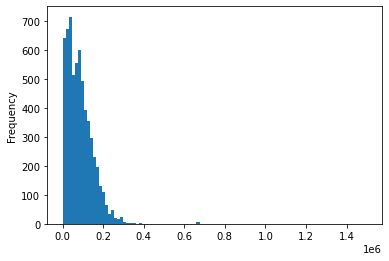

In [13]:
# turn odometer into a numeric value and investigate odometer distribution
car_df["odometer"] = car_df["odometer"].astype(float)
car_df["odometer"].plot.hist(bins=100);

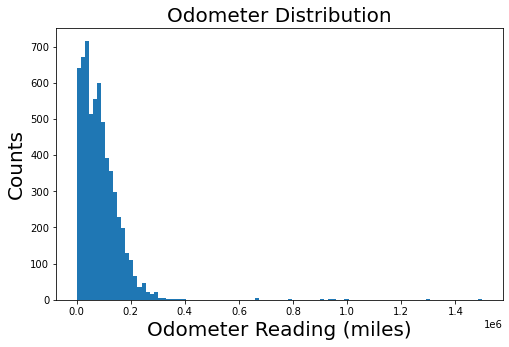

In [14]:
plt.figure(figsize=(8,5))
plt.title("Odometer Distribution", fontsize=20)
plt.xlabel("Odometer Reading (miles)", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.hist(car_df["odometer"], bins=100)
plt.savefig("images/odometer_distribution.png",format='png');

In [15]:
# set any 0 odometer readings to 1 so that I can do a log transform
car_df.loc[car_df["odometer"] == 0, "odometer"] = 1

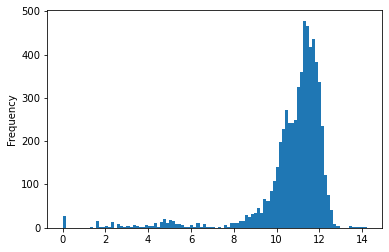

In [16]:
# there are a couple outliers and the data is skewed, so I will add a log transform column
car_df["odometer_log"] = np.log(car_df["odometer"])
car_df["odometer_log"].plot.hist(bins=100);

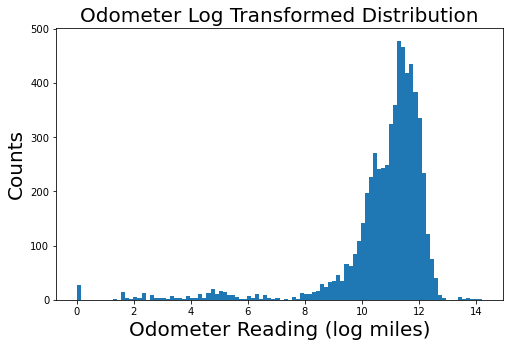

In [17]:
plt.figure(figsize=(8,5))
plt.title("Odometer Log Transformed Distribution", fontsize=20)
plt.xlabel("Odometer Reading (log miles)", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.hist(car_df["odometer_log"], bins=100)
plt.savefig("images/odometer_log_distribution.png",format='png');

In [18]:
# clean up price column
car_df["price"] = car_df["price"].str.replace('$','')

# investigate weird prices
weird_prices = pd.to_numeric(car_df["price"], errors='coerce') # if the price isn't numeric, set value as NaN
car_df[weird_prices.isna()] # turns out price is a period for some rows

print(car_df.shape) # 6,140 rows
car_df = car_df[car_df["price"] != '.']
print(car_df.shape) # 6,134 rows after dropping rows where price is a period meaning 6 rows dropped here
car_df["price"] = car_df["price"].astype(float)
car_df.head()

(6140, 12)
(6134, 12)


,fuel,odometer,title status,transmission,year,price,URL_LOCATION,attribute_number,post_title_length,car_age,car_age_log,odometer_log
0,gas,160000.0,salvage,automatic,2013,10300.0,east_bay,13,43,8,2.079442,11.982929
1,gas,36368.0,clean,automatic,2017,34800.0,north_bay,15,25,4,1.386294,10.501445
2,gas,59541.0,clean,other,2013,17900.0,santa_cruz,13,42,8,2.079442,10.994420
3,gas,102693.0,clean,automatic,2013,8499.0,san_francisco,12,38,8,2.079442,11.539499
4,gas,64183.0,clean,automatic,2012,6499.0,san_francisco,12,39,9,2.197225,11.069494


Investigate and clean up low car prices. Very low prices under 100 (some list 0 or 1 dollar) are suspect and should be removed. Additionally, there are some Craigslist posts for new cars with a monthly lease price.

In [19]:
# Investigate low car prices. Very low prices under $100 (some list $0 or $1) are suspect and should be removed
print(car_df.shape)
car_df = car_df[car_df["price"] > 100]
print(car_df.shape) # 20 rows were dropped

(6134, 12)
(6114, 12)


In [20]:
# drop postings for monthly leases, which I define as a car less than 5 years old with a price under $1000
print(car_df.shape)
car_df = car_df[(car_df["price"] > 999) | (car_df["car_age"] > 5)]
print(car_df.shape) # drop 47 rows

(6114, 12)
(6067, 12)


In [21]:
# double check to see if values make sense
car_df.sort_values(["price"]).head(10)

,fuel,odometer,title status,transmission,year,price,URL_LOCATION,attribute_number,post_title_length,car_age,car_age_log,odometer_log
1773,hybrid,100451.0,clean,automatic,2013,110.0,peninsula,14,45,8,2.079442,11.517425
2157,other,123303.0,clean,automatic,2010,136.0,san_francisco,13,39,11,2.397895,11.722400
2163,other,123303.0,clean,automatic,2010,136.0,san_francisco,13,39,11,2.397895,11.722400
2411,gas,70172.0,clean,automatic,2015,164.0,peninsula,14,36,6,1.791759,11.158705
2146,other,69536.0,clean,automatic,2007,166.0,san_francisco,13,46,14,2.639057,11.149600
1775,gas,63713.0,clean,automatic,2011,197.0,san_francisco,14,44,10,2.302585,11.062144
1916,gas,63713.0,clean,automatic,2011,197.0,east_bay,14,44,10,2.302585,11.062144
2178,other,95017.0,clean,automatic,2013,201.0,san_francisco,13,62,8,2.079442,11.461811
2189,other,88183.0,clean,automatic,2015,201.0,san_francisco,12,69,6,1.791759,11.387169
2190,other,50080.0,clean,automatic,2014,201.0,san_francisco,12,49,7,1.945910,10.821377


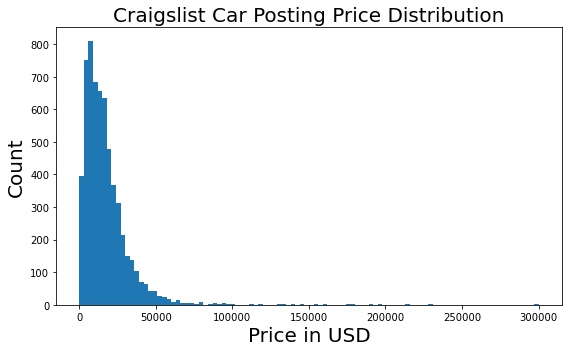

In [22]:
# plot the distribution of price to see if I need to transform it
plt.figure(figsize=(8,5))
plt.hist(car_df["price"], bins=100)
plt.title("Craigslist Car Posting Price Distribution", fontsize=20)
plt.xlabel("Price in USD", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.tight_layout()
plt.savefig("images/price_distribution.png",format='png');

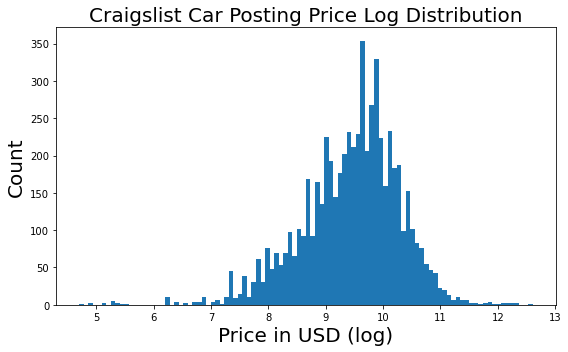

In [23]:
# plotting the log transform of price helps normalize outliers and lessen the skew
plt.figure(figsize=(8,5))
plt.hist(np.log(car_df["price"]), bins=100)
plt.title("Craigslist Car Posting Price Log Distribution", fontsize=20)
plt.xlabel("Price in USD (log)", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.tight_layout()
plt.savefig("images/price_log_distribution.png",format='png');

In [24]:
# add a column for log of price in case I would rather use this in my model
car_df["price_log"] = np.log(car_df["price"])
car_df.sample(5)

,fuel,odometer,title status,transmission,year,price,URL_LOCATION,attribute_number,post_title_length,car_age,car_age_log,odometer_log,price_log
239,hybrid,742.0,clean,automatic,2020,31881.0,east_bay,12,57,1,0.000000,6.609349,10.369766
2471,gas,137107.0,clean,automatic,2010,14995.0,east_bay,12,63,11,2.397895,11.828517,9.615472
2284,gas,119745.0,clean,automatic,2006,3700.0,east_bay,13,39,15,2.708050,11.693120,8.216088
1485,gas,104962.0,clean,automatic,2015,15898.0,east_bay,13,52,6,1.791759,11.561354,9.673949
1679,gas,26012.0,clean,automatic,2017,34500.0,south_bay,13,41,4,1.386294,10.166313,10.448715


In [25]:
# clean up column titles
car_df = car_df.rename(columns={"title status":"title_status", "URL_LOCATION":"location"})

In [26]:
car_df.sample(5)

,fuel,odometer,title_status,transmission,year,price,location,attribute_number,post_title_length,car_age,car_age_log,odometer_log,price_log
245,other,8639.0,clean,automatic,2019,46993.0,san_francisco,11,58,2,0.693147,9.064042,10.757754
2617,gas,205000.0,clean,automatic,1995,2900.0,east_bay,12,22,26,3.258097,12.230765,7.972466
76,gas,158000.0,clean,automatic,2012,5500.0,east_bay,13,24,9,2.197225,11.970350,8.612503
2886,gas,62416.0,clean,automatic,2017,26996.0,south_bay,13,31,4,1.386294,11.041577,10.203444
1605,gas,172000.0,clean,automatic,2009,6888.0,south_bay,14,70,12,2.484907,12.055250,8.837536


In [27]:
# save the cleaned dataframe
with open('data/cleaned_car_df.pickle', 'wb') as to_write:
    pickle.dump(car_df, to_write)

#### 3. Exploratory Data Analysis

Now that I've cleaned my data, I would like to do some exploratory data analysis to see what my data looks like and plan out how I can approach building a regression model.

In [3]:
with open('data/cleaned_car_df.pickle', 'rb') as read_file:
    car_df = pickle.load(read_file)

In [29]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6067 entries, 0 to 1908
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuel               6067 non-null   object 
 1   odometer           6067 non-null   float64
 2   title_status       6067 non-null   object 
 3   transmission       6067 non-null   object 
 4   year               6067 non-null   object 
 5   price              6067 non-null   float64
 6   location           6067 non-null   object 
 7   attribute_number   6067 non-null   int64  
 8   post_title_length  6067 non-null   int64  
 9   car_age            6067 non-null   int64  
 10  car_age_log        6067 non-null   float64
 11  odometer_log       6067 non-null   float64
 12  price_log          6067 non-null   float64
dtypes: float64(5), int64(3), object(5)
memory usage: 663.6+ KB


How do each of my variables correlate to price?

My numeric features are: odometer, odometer_log, attribute_number, post_title_length, car_age, and car_age_log.  
My categorical features are: fuel, title_status, transmission, and location.

In [30]:
def plot_numeric_values(value_list):
    '''
    This function plots a scatter plot for each of the values in value_list vs price.
    Parameters:
        value_list: list of column names
    '''
    
    for idx, value in enumerate(value_list):
        
        plt.figure(figsize=(8, 8))
        plt.subplot(len(value_list), 1, idx + 1)
        plt.scatter(car_df[value], car_df["price"], alpha=0.1)
        plt.xlabel(f"{value}")
        plt.ylabel("Price in USD")
        plt.ylim([0, 310000])
        plt.title(f"{value} vs. Price Distribution");

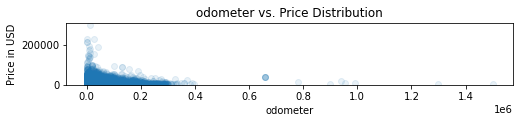

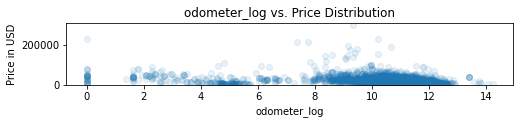

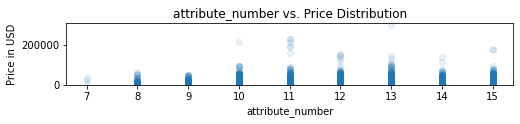

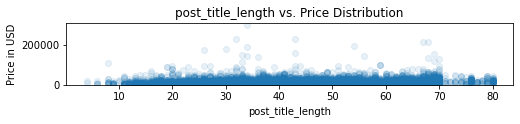

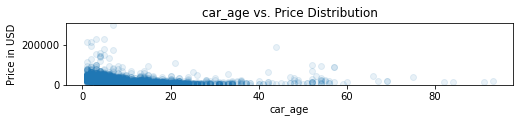

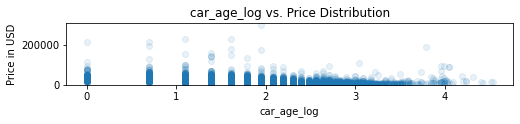

In [31]:
numeric_value_list = ["odometer", "odometer_log", "attribute_number", "post_title_length", "car_age", "car_age_log"]
plot_numeric_values(numeric_value_list)

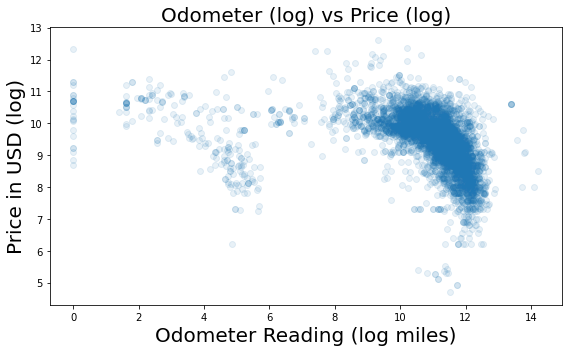

In [32]:
plt.figure(figsize=(8,5))
plt.scatter(car_df["odometer_log"], car_df["price_log"], alpha=0.1)
plt.title("Odometer (log) vs Price (log)", fontsize=20)
plt.xlabel("Odometer Reading (log miles)", fontsize=20)
plt.ylabel("Price in USD (log)", fontsize=20)
plt.tight_layout()
plt.savefig("images/odometer_price_log_comparison.png",format='png');

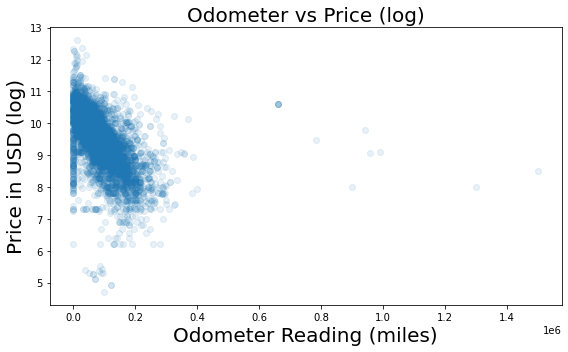

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(car_df["odometer"], car_df["price_log"], alpha=0.1)
plt.title("Odometer vs Price (log)", fontsize=20)
plt.xlabel("Odometer Reading (miles)", fontsize=20)
plt.ylabel("Price in USD (log)", fontsize=20)
plt.tight_layout()
plt.savefig("images/odometer_price_log_comparison2.png",format='png');

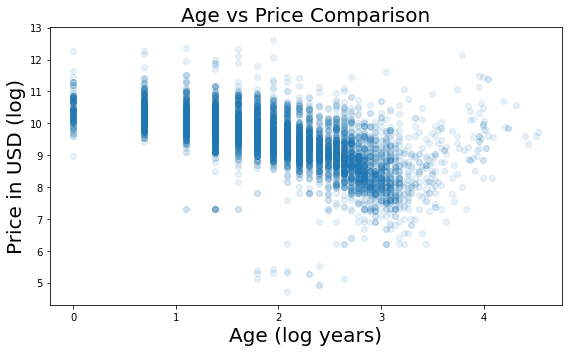

In [33]:
plt.figure(figsize=(8,5))
plt.scatter(car_df["car_age_log"], car_df["price_log"], alpha=0.1)
plt.title("Age vs Price Comparison", fontsize=20)
plt.xlabel("Age (log years)", fontsize=20)
plt.ylabel("Price in USD (log)", fontsize=20)
plt.tight_layout()
plt.savefig("images/age_price_log_comparison.png",format='png');

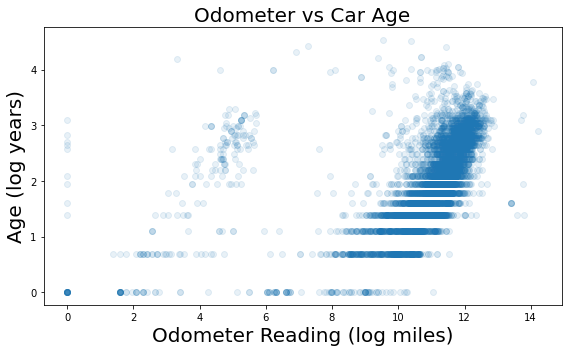

In [34]:
plt.figure(figsize=(8,5))
plt.scatter(car_df["odometer_log"], car_df["car_age_log"], alpha=0.1)
plt.title("Odometer vs Car Age", fontsize=20)
plt.xlabel("Odometer Reading (log miles)", fontsize=20)
plt.ylabel("Age (log years)", fontsize=20)
plt.tight_layout()
plt.savefig("images/odometer_age_log_comparison.png",format='png');

Thoughts on the distributions: <br/>
* Odometer vs price shows a pretty clear negative correlation, but odometer log vs price makes that harder to see.
* There's not a clear relationship between attribute number and price. It looks like there might be a slight increase in price the more attributes there are.
* There's an extremely slight increase in price when post title length increases, but the data isn't very clear.
* Car age and car age log show a clear negative correlation with price.

In [35]:
def plot_categorical_values(value_list):
    '''
    This function plots a boxplot for each of the values in value_list vs price.
    Parameters:
        value_list: list of column names
    '''    
    for idx, value in enumerate(value_list):
    
        plt.figure(figsize=(8, 10))
        plt.subplot(len(value_list), 1, idx + 1)
        sns.boxplot(x = value, y = "price", data=car_df, palette="GnBu")
        plt.xlabel(f"{value}")
        plt.ylabel("Price in USD")
        plt.ylim([0, 100000])
        plt.title(f"{value} vs. Price Distribution");

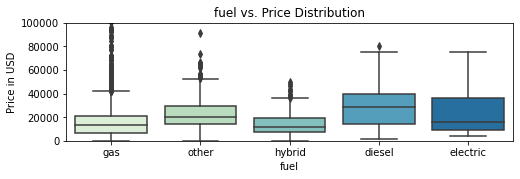

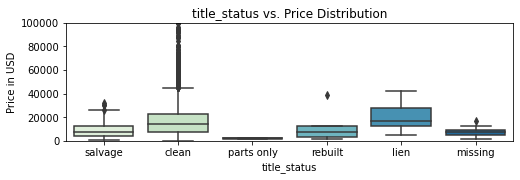

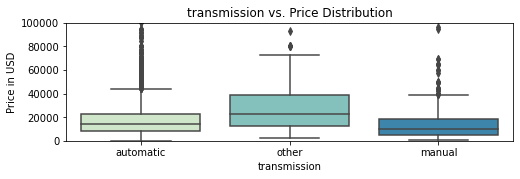

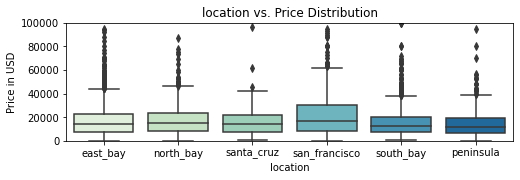

In [36]:
categorical_value_list = ["fuel", "title_status", "transmission", "location"]
plot_categorical_values(categorical_value_list)

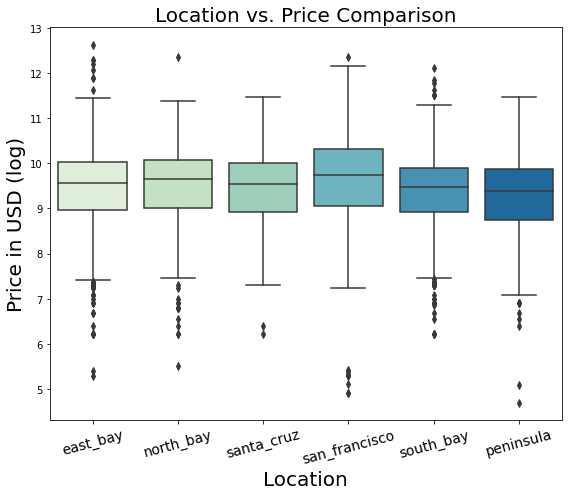

In [37]:
plt.figure(figsize=(8, 7))
sns.boxplot(x = "location", y = "price_log", data=car_df, palette="GnBu")
plt.xlabel("Location", fontsize=20)
plt.ylabel("Price in USD (log)", fontsize=20)
plt.title("Location vs. Price Comparison", fontsize=20)
plt.xticks(rotation=15,fontsize=14)
plt.tight_layout()
plt.savefig("images/location_price_log_comparison.png",format='png');

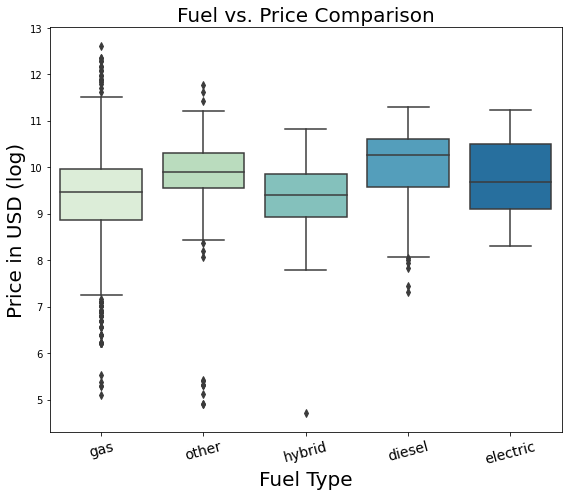

In [46]:
plt.figure(figsize=(8, 7))
sns.boxplot(x = "fuel", y = "price_log", data=car_df, palette="GnBu")
plt.xlabel("Fuel Type", fontsize=20)
plt.ylabel("Price in USD (log)", fontsize=20)
plt.title("Fuel vs. Price Comparison", fontsize=20)
plt.xticks(rotation=15,fontsize=14)
plt.tight_layout()
plt.savefig("images/fuel_price_log_comparison.png",format='png');

Thoughts on the distributions: <br/>
* Gas and hybrid fuel are generally cheaper than cars that use other fuel types, but gas has many outliers that are very expensive. I will need to look at the value counts to get a better sense of how strong the relationship is between fuel type and price.
* Similar to gas fuel, a clean title status has many outliers. There do appear to be differences, but I will need to look at the value counts because I suspect the large majority of cars listed have a clean title.
* Yet again, there are many outliers for automatic transmission car prices.
* One of the most interesting graphs. It seems like San Francisco cars may be slightly more expensive and South bay cars are slightly cheaper.

In [38]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6067 entries, 0 to 1908
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuel               6067 non-null   object 
 1   odometer           6067 non-null   float64
 2   title_status       6067 non-null   object 
 3   transmission       6067 non-null   object 
 4   year               6067 non-null   object 
 5   price              6067 non-null   float64
 6   location           6067 non-null   object 
 7   attribute_number   6067 non-null   int64  
 8   post_title_length  6067 non-null   int64  
 9   car_age            6067 non-null   int64  
 10  car_age_log        6067 non-null   float64
 11  odometer_log       6067 non-null   float64
 12  price_log          6067 non-null   float64
dtypes: float64(5), int64(3), object(5)
memory usage: 823.6+ KB


In [39]:
# look at cylinders, drive, fuel, odometer, transmission, type value counts to see which categorical variable to drop when making dummy variables
print(car_df["fuel"].value_counts()) # drop values for "fuel_other"
print(car_df["title_status"].value_counts()) # drop values for "title_status parts only"
print(car_df["transmission"].value_counts()) # drop values for "transmission_other"
print(car_df["location"].value_counts()) # drop values for "location_santa_cruz"

gas         5068
other        332
hybrid       300
diesel       280
electric      87
Name: fuel, dtype: int64
clean         5840
salvage        186
missing         14
rebuilt         13
lien            12
parts only       2
Name: title_status, dtype: int64
automatic    5529
manual        438
other         100
Name: transmission, dtype: int64
east_bay         2566
south_bay        1425
north_bay         751
san_francisco     656
peninsula         488
santa_cruz        181
Name: location, dtype: int64
